In [38]:
import pandas as pd
import numpy as np

df = pd.read_excel("Test.xlsx")


df.dropna(inplace=True)

df['timestamp'] = pd.to_datetime(df['timestamp'])

df['date'] = df['timestamp'].dt.date
df['time'] = df['timestamp'].dt.time
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['month'] = df['timestamp'].dt.month
df['year'] = df['timestamp'].dt.year

df['WindDirection'] = df['WindDirection'].map({'N': 0, 'E': 90, 'S': 180, 'W': 270})

df.to_csv("Preprocessed_Test.csv", index=False)


In [49]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
import matplotlib.pyplot as plt


In [50]:
train_data = pd.read_csv("Preprocessed_Train.csv")
test_data = pd.read_csv("Preprocessed_Test.csv")


In [51]:
feature = 'Temperature'
train_data = train_data[['timestamp', feature]].set_index('timestamp')
test_data = test_data[['timestamp', feature]].set_index('timestamp')


In [52]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.transform(test_data)


In [53]:
def create_time_series_data(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)


In [54]:
sequence_length = 10

# Create time series data for LSTM
X_train, y_train = create_time_series_data(train_data_scaled, sequence_length)
X_test, y_test = create_time_series_data(test_data_scaled, sequence_length)


In [55]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


In [56]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(sequence_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')


In [57]:
model.fit(X_train, y_train, epochs=50, batch_size=32)


Epoch 1/50
1209/1209 [==============================] - 4s 3ms/step - loss: 0.0067
Epoch 2/50
1209/1209 [==============================] - 3s 3ms/step - loss: 4.3277e-04
Epoch 3/50
1209/1209 [==============================] - 3s 3ms/step - loss: 3.5713e-04
Epoch 4/50
1209/1209 [==============================] - 3s 3ms/step - loss: 3.1344e-04
Epoch 5/50
1209/1209 [==============================] - 3s 3ms/step - loss: 3.1277e-04
Epoch 6/50
1209/1209 [==============================] - 3s 3ms/step - loss: 2.8858e-04
Epoch 7/50
1209/1209 [==============================] - 3s 3ms/step - loss: 2.8961e-04
Epoch 8/50
1209/1209 [==============================] - 3s 3ms/step - loss: 2.8318e-04
Epoch 9/50
1209/1209 [==============================] - 3s 3ms/step - loss: 2.7947e-04
Epoch 10/50
1209/1209 [==============================] - 3s 3ms/step - loss: 2.7935e-04
Epoch 11/50
1209/1209 [==============================] - 3s 3ms/step - loss: 2.7763e-04
Epoch 12/50
1209/1209 [======================

In [58]:
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)


23/23 [==============================] - 0s 1ms/step


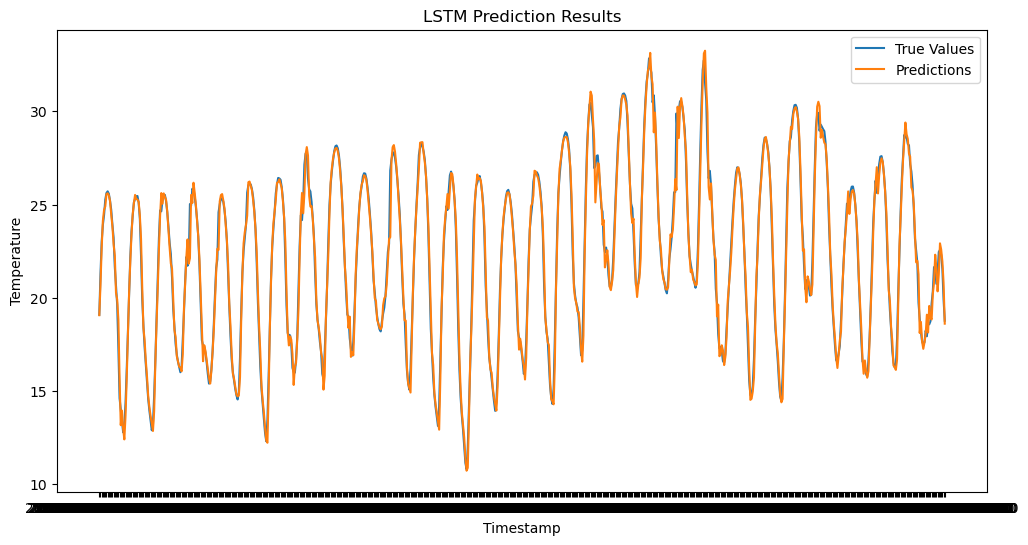

In [59]:
plt.figure(figsize=(12, 6))
plt.plot(test_data.index[sequence_length:],
         test_data[feature][sequence_length:], label='True Values')
plt.plot(test_data.index[sequence_length:], y_pred, label='Predictions')
plt.xlabel('Timestamp')
plt.ylabel(feature)
plt.title('LSTM Prediction Results')
plt.legend()
plt.show()


In [60]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate predictions on the test set
y_true = test_data[feature][sequence_length:]
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")


Mean Squared Error (MSE): 0.33
Mean Absolute Error (MAE): 0.39
